In [3]:
from sklearn.model_selection import train_test_split 
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt

import random
import math
import os

In [4]:
def g(x):
    if x == 1:
        return "Heart Disease"
    return 'Healthy'

In [5]:
df = pd.read_csv("../data/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
print(len(df[df["HeartDisease"] == 1]))
print(len(df[df["HeartDisease"] == 1])/len(df)*100)

508
55.33769063180828


The unique values in Sex are: 
 ['M' 'F']


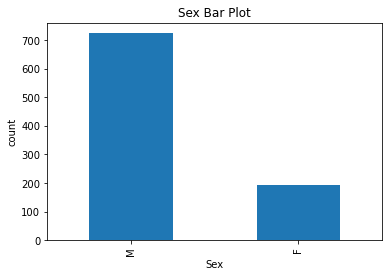

The unique values in ChestPainType are: 
 ['ATA' 'NAP' 'ASY' 'TA']


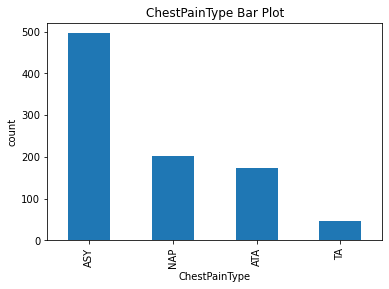

The unique values in FastingBS are: 
 [0 1]


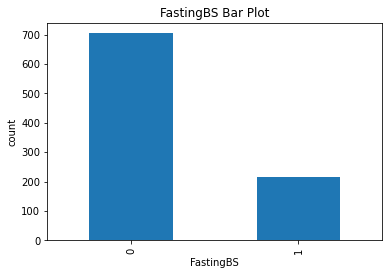

The unique values in RestingECG are: 
 ['Normal' 'ST' 'LVH']


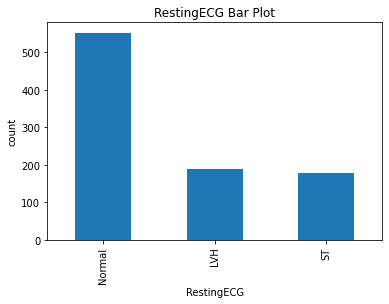

The unique values in ExerciseAngina are: 
 ['N' 'Y']


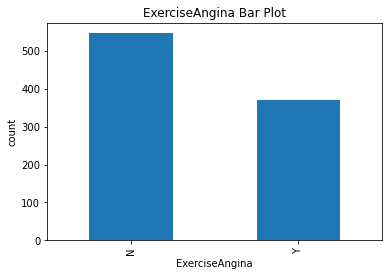

The unique values in ST_Slope are: 
 ['Up' 'Flat' 'Down']


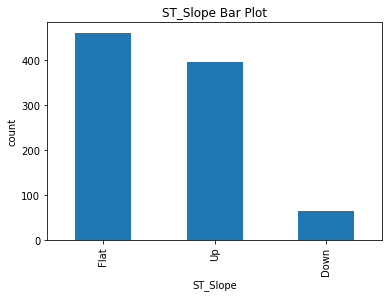

In [8]:
is_categorical = ["Sex","ChestPainType","FastingBS","RestingECG","ExerciseAngina","ST_Slope"]
for col in is_categorical: # this serves to show the range of each categorical feature while looking for missing datapoints.
    print(f'The unique values in {col} are: \n {df[col].unique()}')
    pd.value_counts(df[col]).plot.bar()
    plt.ylabel('count')
    plt.xlabel(col)
    plt.title(col + ' Bar Plot')
    plt.savefig(f"../figures/{col}_bar.png",bbox_inches="tight", dpi = 300)
    plt.show()

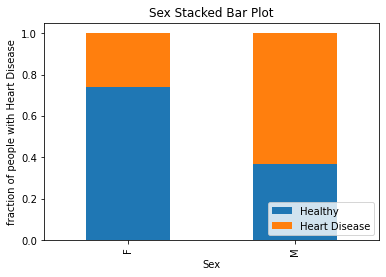

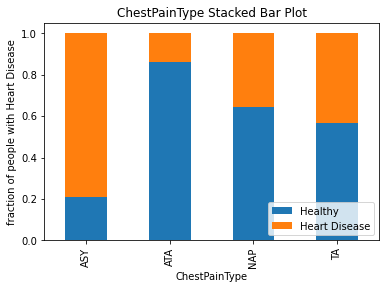

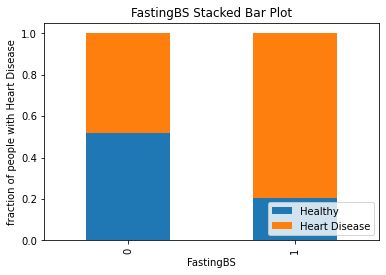

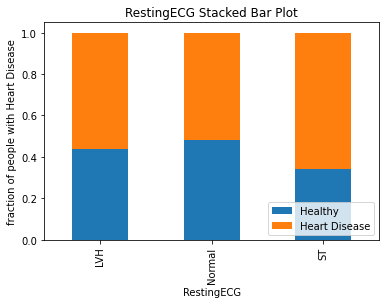

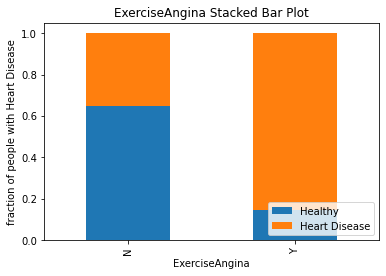

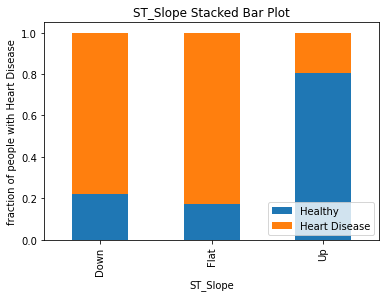

In [9]:

for col in is_categorical: #compare teh categorical datapoints to the target var
    count_matrix = df.groupby([col, 'HeartDisease']).size().unstack()
    count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
    count_matrix_norm.plot(kind='bar', stacked=True)
    plt.ylabel('fraction of people with Heart Disease')
    plt.legend(["Healthy","Heart Disease"],loc = 4)
    plt.title(f"{col} Stacked Bar Plot")
    plt.savefig(f"../figures/{col}_stacked_bar.png",bbox_inches="tight", dpi = 300)
    plt.show()

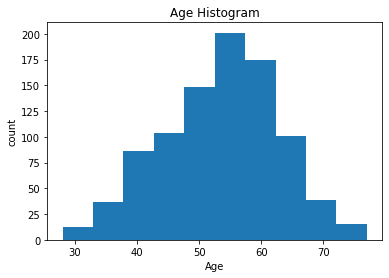

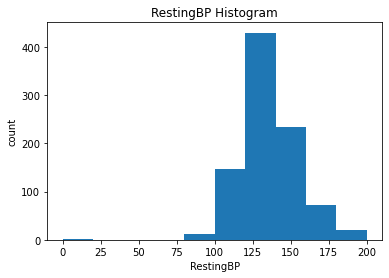

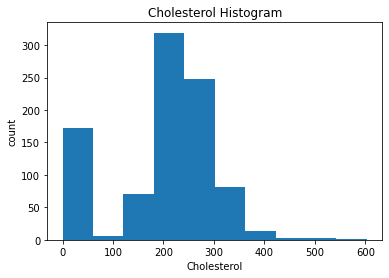

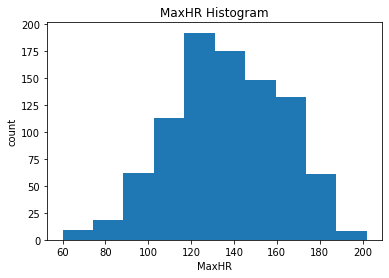

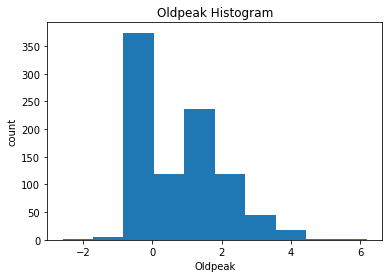

In [10]:
is_continuous = ["Age","RestingBP","Cholesterol","MaxHR", "Oldpeak"]
bins = [12 for _ in range(1,len(is_continuous))]
for col in is_continuous:
    df[col].plot.hist()
    plt.xlabel(col)
    plt.ylabel('count')
    plt.title(f"{col} Histogram")
    plt.savefig(f"../figures/{col}_hist.png",bbox_inches="tight", dpi = 300)
    plt.show()

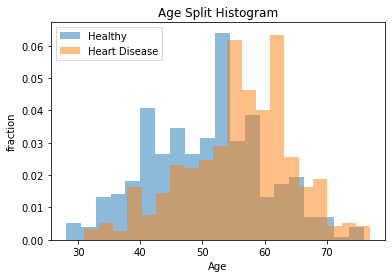

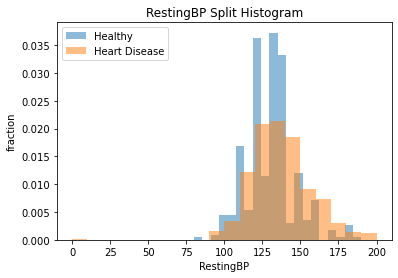

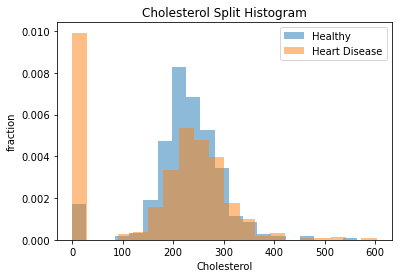

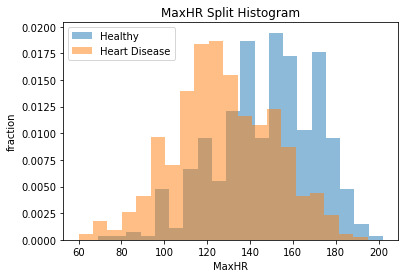

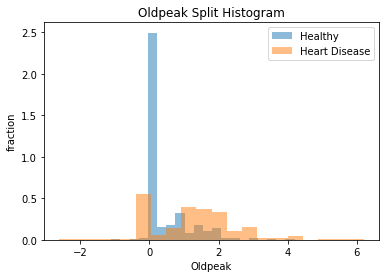

In [11]:
for col in is_continuous:
    categories = df['HeartDisease'].unique()
    
    for c in categories:
        plt.hist(df[df['HeartDisease']==c][col],alpha=0.5,label=g(c),bins=20,density=True)
    plt.legend()
    plt.ylabel('fraction')
    plt.xlabel(col)
    plt.title(f"{col} Split Histogram")
    plt.savefig(f"../figures/{col}_split_hist.png",bbox_inches="tight", dpi = 300)
    plt.show()
    

In [12]:
#it is worth noting here that the Oldpeak histogram is not meaningful as it has an impossible value in it.

In [13]:
len(df[df["Cholesterol"] ==0])
# here we see 172 people have cholesterol encoded as 0 which must be a missing value.

172

In [14]:
len(df[df["RestingBP"] == 0])
#and one patient does not have blood pressure. missing data point.

1

In [15]:
len(df[df["Oldpeak"] == 0]) 
#oldpeak of 0 is normal and healthy however other missing data
#is encoded as zero and so a fraction of these points mmight be meaningless

368

In [16]:
len(df[df["Oldpeak"] < 0]) #negative old peaks are considered outside of the range of this function but are possible

13

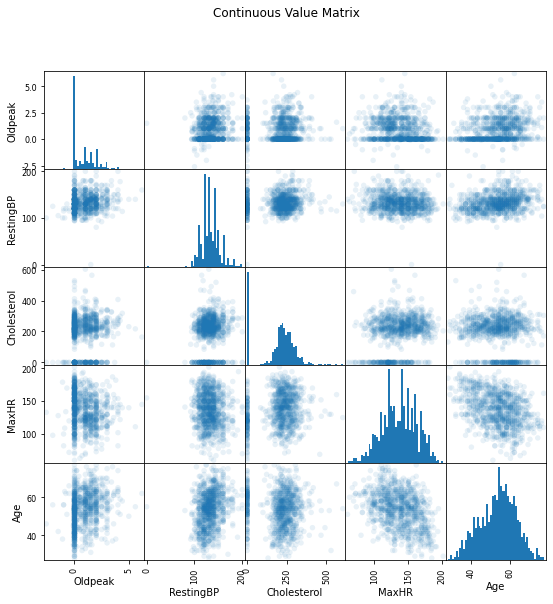

In [17]:
pd.plotting.scatter_matrix(df[['Oldpeak','RestingBP','Cholesterol','MaxHR','Age']], figsize=(9, 9), marker='o',hist_kwds={'bins': 50}, 
                           s=30, alpha=.1)
plt.suptitle("Continuous Value Matrix")
plt.savefig("../figures/matrix.png",dpi=300,bbox_inches="tight")
plt.show() #just checking this out, none are particularly helpful no clear relationships beyond the expected.

### Here we begin preprocessing the data:

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
random_state = 73

In [19]:
df['Cholesterol'] = df['Cholesterol'].replace(0,np.nan) # replace junk values with nan
df['RestingBP'] = df['RestingBP'].replace(0,np.nan)

y = df['HeartDisease'] # assign our attributes and target variable
X = df.loc[:, df.columns != 'HeartDisease']

In [20]:
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.7,random_state=random_state)
X_test,X_val,y_test,y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=random_state)

In [21]:
ordinal_ftrs = [] 
ordinal_cats = []
onehot_ftrs = ["Sex","ChestPainType","FastingBS","RestingECG","ExerciseAngina","ST_Slope"]
minmax_ftrs = is_continuous = ["Age","RestingBP","Cholesterol","MaxHR"]
std_ftrs = ["Oldpeak"]


preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) 

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

In [22]:
np.shape(X_train_prep) #the number of features in the transformed dataset

(642, 21)

In [23]:
print(np.shape(X_val_prep))
print(np.shape(X_test_prep))

(138, 21)
(138, 21)


In [24]:
#Here we can test reproducability:

df['Cholesterol'] = df['Cholesterol'].replace(0,np.nan) # replace junk values with nan
df['RestingBP'] = df['RestingBP'].replace(0,np.nan)

y = df['HeartDisease'] # assign our attributes and target variable
X = df.loc[:, df.columns != 'HeartDisease']
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.7,random_state=random_state)
X_test,X_val,y_test,y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=random_state)


ordinal_ftrs = [] 
ordinal_cats = []
onehot_ftrs = ["Sex","ChestPainType","FastingBS","RestingECG","ExerciseAngina","ST_Slope"]
minmax_ftrs = is_continuous = ["Age","RestingBP","Cholesterol","MaxHR"]
std_ftrs = ["Oldpeak"]


preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) 

X_train_prep2 = clf.fit_transform(X_train)
X_val_prep2 = clf.transform(X_val)
X_test_prep2 = clf.transform(X_test)
print(np.array_equal(X_train_prep2, X_train_prep, equal_nan = True))
print(np.array_equal(X_val_prep2, X_val_prep, equal_nan = True))
print(np.array_equal(X_test_prep2, X_test_prep, equal_nan = True))

True
True
True


In [25]:
import xgboost

In [26]:
X_train_prep
X_val_prep
X_test_prep

array([[ 1.        ,  0.        ,  1.        , ...,  0.24850895,
         0.38028169,  0.12206142],
       [ 0.        ,  1.        ,  0.        , ...,  0.47514911,
         0.47183099,  0.76740732],
       [ 0.        ,  1.        ,  0.        , ...,  0.13121272,
         0.56338028, -0.7998613 ],
       ...,
       [ 0.        ,  1.        ,  1.        , ...,  0.31610338,
         0.49295775,  1.96590685],
       [ 0.        ,  1.        ,  0.        , ...,         nan,
         0.44366197,  0.39863823],
       [ 0.        ,  1.        ,  1.        , ...,  0.49502982,
         0.42253521,  0.12206142]])

In [27]:
tr_means =[]
tr_stdevs = []
val_means = []
val_stdevs = []
depths = [1,2,3,4,5,6,7,8,9,10,12,15,20,25,30]
for max_depth in depths:    
    # fit_transform the training set
    
    train_scores =[]
    val_scores = []

    for random_state in [12,34,56,765,23]:
        #print(f"random state = {random_state}")
        
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.7,random_state=random_state)
        X_test,X_val,y_test,y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=random_state)
        
        
        
        X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state)
        X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=random_state)
        X_prep = preprocessor.fit_transform(X_train)
        # little hacky, but collect feature names
        feature_names = preprocessor.transformers_[0][-1] + \
                        list(preprocessor.named_transformers_['cat'][0].get_feature_names(cat_ftrs)) + \
                        preprocessor.transformers_[2][-1]
        #print(feature_names)
        df_train = pd.DataFrame(data=X_prep,columns=feature_names)
        #print(df_train.shape)

        # transform the CV
        df_CV = preprocessor.transform(X_CV)
        df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
        #print(df_CV.shape)

        # transform the test
        df_test = preprocessor.transform(X_test)
        df_test = pd.DataFrame(data=df_test,columns = feature_names)
        #print(df_test.shape)
        
        param_grid = {"learning_rate": [0.03],
                      "n_estimators": [10000],
                      "seed": [0],
                      "reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                      "reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                      "missing": [np.nan], 
                      "max_depth": [max_depth],
                      "colsample_bytree": [0.9],              
                      "subsample": [0.66],
                      "random_state": [random_state]}
        pg = ParameterGrid(param_grid)
        md = 0
        best_score = 0
        best_score_i = 0
        for i in range(len(pg)):
            #print(pg[i])
            XGB = xgboost.XGBRegressor()
            XGB.set_params(**pg[i])
            XGB.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_CV, y_CV)], verbose=False)

            y_CV_pred = XGB.predict(df_CV)
            #print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))
            y_test_pred = XGB.predict(df_test)
            #print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))

            y_train_pred = XGB.predict(df_train)
            test_score = r2_score(y_test,y_test_pred)
            if test_score > best_score:
                best_score = test_score
                best_score_i = i
                md = XGB.get_params()['max_depth']
        XGB = xgboost.XGBRegressor()
        XGB.set_params(**pg[best_score_i])
        XGB.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_CV, y_CV)], verbose=False)

        y_train_pred = XGB.predict(df_train)
        y_CV_pred = XGB.predict(df_CV)

    
        train_scores.append(r2_score(y_train,y_train_pred))
        val_scores.append(r2_score(y_CV,y_CV_pred))
    tr_means.append(np.mean(train_scores))
    tr_stdevs.append(np.std(train_scores))
    val_means.append(np.mean(val_scores))
    val_stdevs.append(np.std(val_scores))

KeyError: 'cat'

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
error_rate= []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_prep,y_train)
    pred_i = knn.predict(X_test_prep)
    error_rate.append(np.mean(pred_i != y_test))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').